*Extra analysis of the subway service ridership scripts*. In particular, applying different factors to get a better estimate of 2025 ridership. 

# Imports/Installation

In [3]:
import gtfs_kit as gk
import pandas as pd 
import folium
from geodatasets import get_path
import shapely
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import tab20
import matplotlib.cm as cm
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 150
sns.set(style='whitegrid')

In [4]:
orig_stations_df = pd.read_csv("../data/MTA_Subway_Stations_20240325.csv")
orig_stations_df = orig_stations_df[orig_stations_df['Borough']!='SI'] 
orig_stations_df = orig_stations_df.drop(columns=['Division', 'ADA', 'ADA Northbound', 'ADA Southbound', 'ADA Notes'
                                                , 'North Direction Label', 'South Direction Label'])

In [5]:
yearly_ridership = pd.read_csv("../saved_data/routes_yearly_ridership.csv", index_col=0)

In [6]:
yearly_ridership

,route_id,yearly_ridership_MM,frequency_capacity,crowdedness,yearly_ridership_unlinked_MM,Adjusted_unlinked_2025,crowdedness_unlinked
0,1,100.75,197703000.0,0.51,170.44,184.65,0.93
1,6,99.03,206785800.0,0.48,167.53,181.50,0.88
2,7,94.55,153885600.0,0.61,159.95,173.29,1.13
3,F,86.38,264496960.0,0.33,146.13,158.32,0.60
4,R,79.55,189355440.0,0.42,134.58,145.80,0.77
5,N,70.85,174437216.0,0.41,119.86,129.85,0.74
6,A,67.87,200473280.0,0.34,114.82,124.39,0.62
7,E,64.44,131762400.0,0.49,109.02,118.11,0.90
8,Q,62.18,150739360.0,0.41,105.19,113.96,0.76
9,2,58.72,190656000.0,0.31,99.33,107.62,0.56


## Plots of Service Ridership

<Axes: >

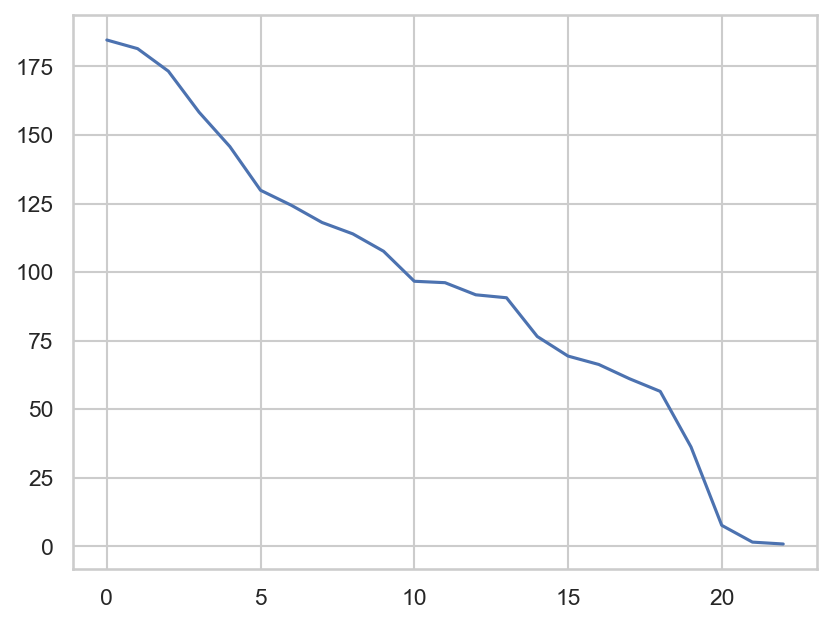

In [65]:
# speed, especially at late nights, depends on how "local" the services are
yearly_ridership['Adjusted_unlinked_2025'].plot()

In [66]:
color_list = ['#D82233', '#9A38A1', '#009952', '#EB6800', '#F6BC26', '#F6BC26'
              , '#0062CF', '#0062CF', '#F6BC26', '#D82233', '#7C858C'
              , '#009952', '#0062CF', '#EB6800', '#D82233', '#009952',
              '#EB6800', '#EB6800', '#8E5C33', '#799534'
              , '#7C858C','#7C858C', '#7C858C']

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_59650/2186327891.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(yearly_ridership, x='route_id', y='Adjusted_unlinked_2025'


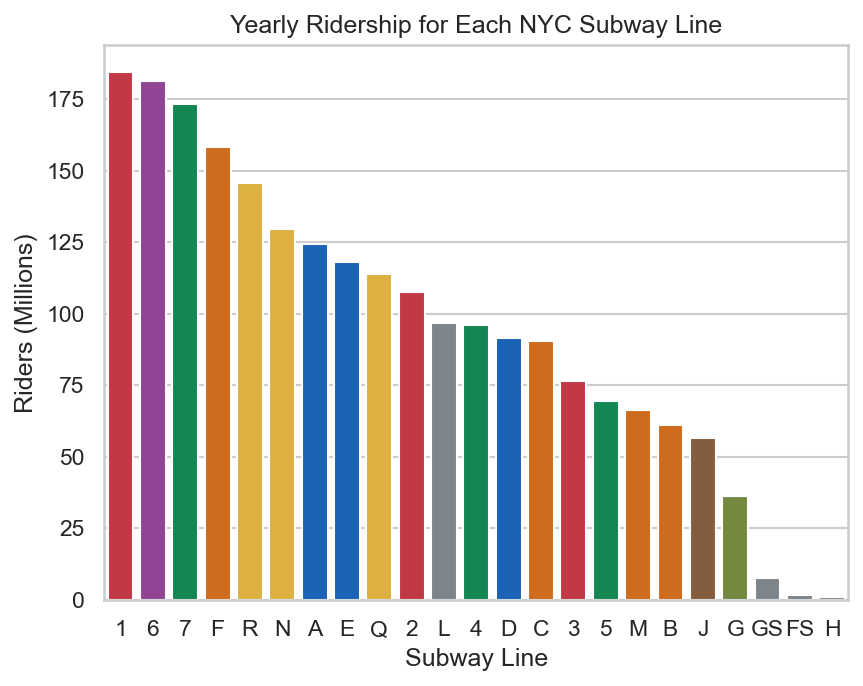

In [ ]:
ax = sns.barplot(yearly_ridership, x='route_id', y='Adjusted_unlinked_2025'
            , palette=sns.color_palette(color_list))
ax.set_title("Yearly Ridership for Each NYC Subway Line")
ax.set_ylabel("Riders (Millions)")
ax.set_xlabel("Subway Line")
fig = ax.get_figure()
fig.savefig("../saved_data/yearly_service_ridership_plot.png")

## Plotting Crowdedness

In [93]:
color_list_crowdedness = [ '#7C858C', '#9A38A1', '#D82233', '#0062CF', '#009952'
              , '#0062CF', '#EB6800', '#F6BC26', '#F6BC26', '#EB6800', '#D82233'
              , '#009952','#F6BC26', '#799534',  '#009952', '#0062CF',
              '#EB6800', '#EB6800', '#7C858C', '#D82233'
              , '#7C858C', '#8E5C33','#F6BC26']

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_59650/819378537.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(yearly_ridership_corwdedness_sort, x='route_id', y='crowdedness_unlinked'


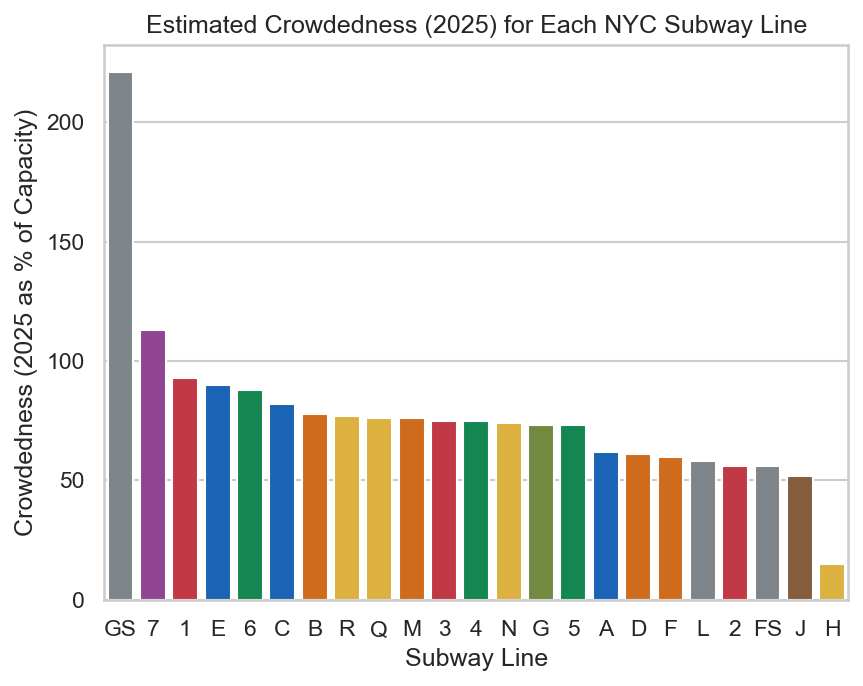

In [96]:
yearly_ridership_corwdedness_sort = yearly_ridership.sort_values(by='crowdedness_unlinked', ascending=False)
yearly_ridership_corwdedness_sort['crowdedness_unlinked'] = yearly_ridership_corwdedness_sort['crowdedness_unlinked'] * 100
ax = sns.barplot(yearly_ridership_corwdedness_sort, x='route_id', y='crowdedness_unlinked'
            , palette=sns.color_palette(color_list_crowdedness))
ax.set_title("Estimated Crowdedness (2025) for Each NYC Subway Line")
ax.set_ylabel("Crowdedness (2025 as % of Capacity)")
ax.set_xlabel("Subway Line")
fig = ax.get_figure()
fig.savefig("../saved_data/yearly_crowdedness_plot.png")

# Comparing to MTA Pre-Covid Rush Hour Data

In [ ]:
a_div_df = pd.read_csv("../one_off_data/A_division_peak.txt", header=None)
a_div_df.columns = ['service', 'peak_load_point', 'peak_volume', 'tph', 'v/c_ratio']
a_div_df = a_div_df[['service', 'peak_volume']]
a_div_df = pd.DataFrame(a_div_df.groupby('service')['peak_volume'].sum()).reset_index().sort_values(by='peak_volume')

In [51]:

b_div_df = pd.read_csv("../one_off_data/B_division_peak.txt", header=None)
b_div_df.columns = ['service', 'peak_load_point', 'peak_volume', 'tph', 'v/c_ratio']
b_div_df = b_div_df[['service', 'peak_volume']]
b_div_df = pd.DataFrame(b_div_df.groupby('service')['peak_volume'].sum()).reset_index().sort_values(by='peak_volume')

In [ ]:
peak_service_volume_df = pd.concat([a_div_df, b_div_df]).sort_values(by='peak_volume')

In [56]:
peak_service_volume_df

,service,peak_volume
7,S,6269
7,J,10007
6,G,10534
2,C,12925
0,1,12928
12,R,15959
9,M,16183
1,B,18363
2,3,19563
1,2,19663
